<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/1015.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install umap-learn[plot] hdbscan kneed

## Clustering digits with DBSCAN

In [2]:
import random

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import fetch_openml
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score

import umap
import umap.plot as uplot

import hdbscan
import hdbscan.validity

from kneed import KneeLocator

from sklearn.decomposition import PCA

random.seed(2)
sns.set_theme()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn

### Load the digit dataset

In [3]:
# Load digits data
mnist = fetch_openml('mnist_784', parser='auto')

# Normalize digits data
digits_data = mnist.data/255
digit_labels = mnist.target

# Subset the dataset
digit_labels_df = pd.DataFrame(digit_labels)

label_subset_df = digit_labels_df.groupby('class').head(2000) # we will subset the data set, and we will retain 2000 samples for each class

digits_data = digits_data.loc[label_subset_df.index, :].reset_index(drop=True)
digit_labels = label_subset_df['class'].to_numpy()

<ipython-input-3-4086e33c0366>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_subset_df = digit_labels_df.groupby('class').head(2000) # we will subset the data set, and we will retain 2000 samples for each class


In [4]:
digits_data.shape

(20000, 784)

<Axes: >

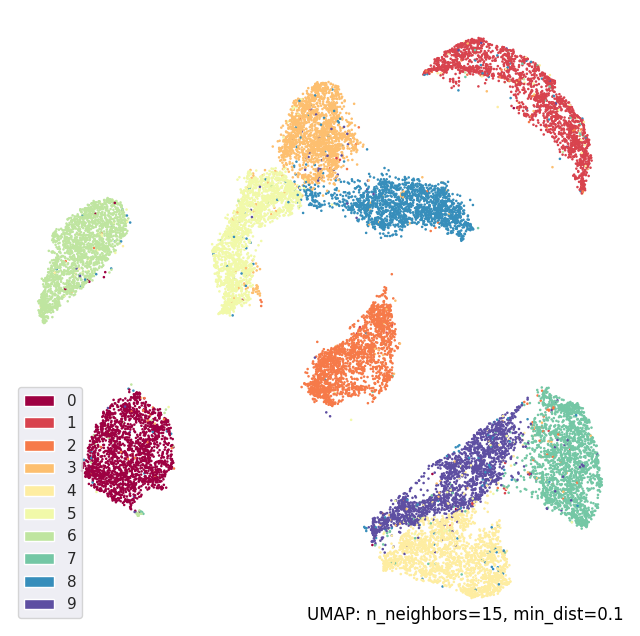

In [5]:
# Default values
umap_obj = umap.UMAP()
embedding = umap_obj.fit_transform(digits_data)

uplot.points(umap_obj, labels=digit_labels)

### Dbscan - default parameter choosing methods

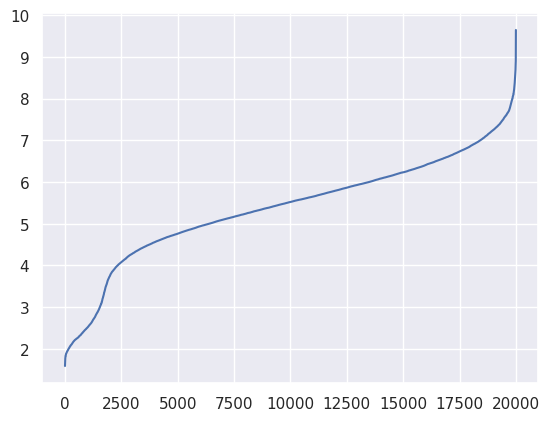

In [6]:
# since the dimensionality of this data set is really high and it is high compared to the number of samples,
# in this case we will use the logarithm of the data set size as a minimal number of points
# Identify MinPts # todo_spencer
min_pts = int(np.log(digits_data.shape[0]))

# we will use the knee method in order to choose to choose value for eps
# Find distances to min_pts'th neighbor
knn = NearestNeighbors()
knn.fit(digits_data)
distances, _ = knn.kneighbors(digits_data, n_neighbors=min_pts)

# Sort the dsitances to min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

# Plot and search for the knee
plt.plot(range(sort_dist.shape[0]), sort_dist)

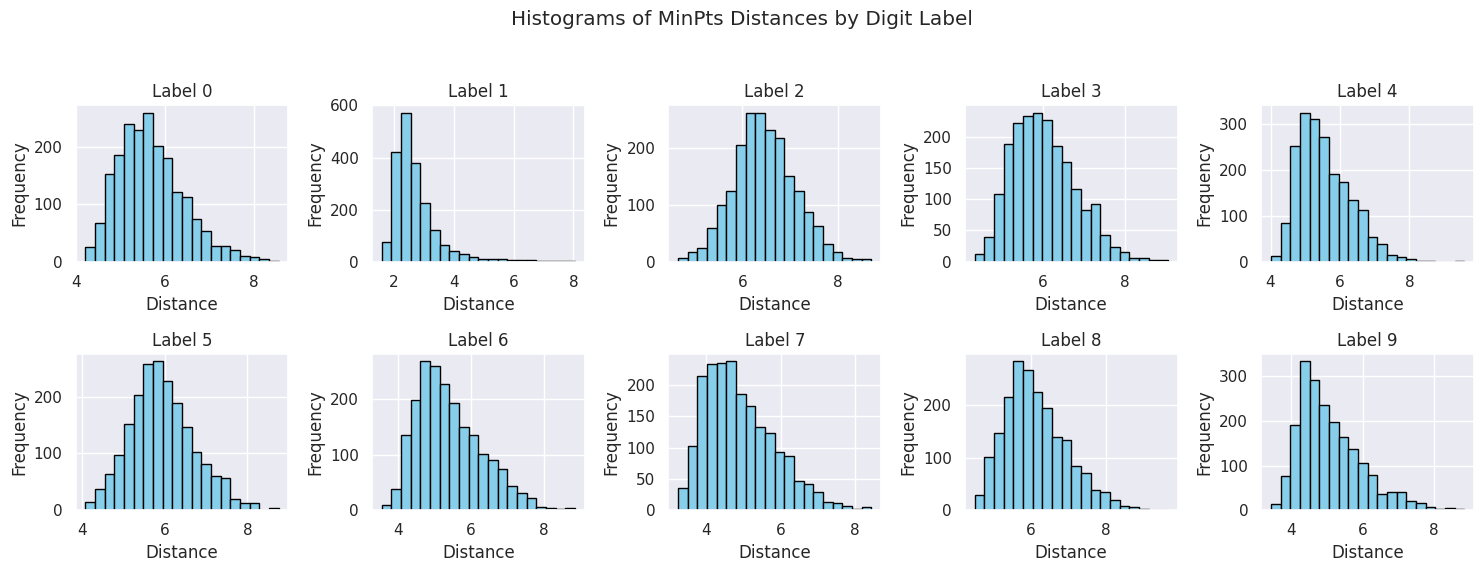

In [7]:
distances_min_pts = distances[:, -1]

# 建立每個標籤的距離資料
distances_by_label = {label: [] for label in np.unique(digit_labels)}
for i, label in enumerate(digit_labels):
    distances_by_label[label].append(distances_min_pts[i])

# 繪製每個標籤的距離直方圖
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
fig.suptitle('Histograms of MinPts Distances by Digit Label')
for label, ax in zip(distances_by_label.keys(), axes.flatten()):
    ax.hist(distances_by_label[label], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Label {label}')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
# Cluster again
dbscan_tun = DBSCAN(eps=6, min_samples=min_pts)
_ = dbscan_tun.fit(digits_data)

np.unique(dbscan_tun.labels_)

array([-1,  0,  1,  2,  3])

ARI : 0.011411391663305983


<Axes: >

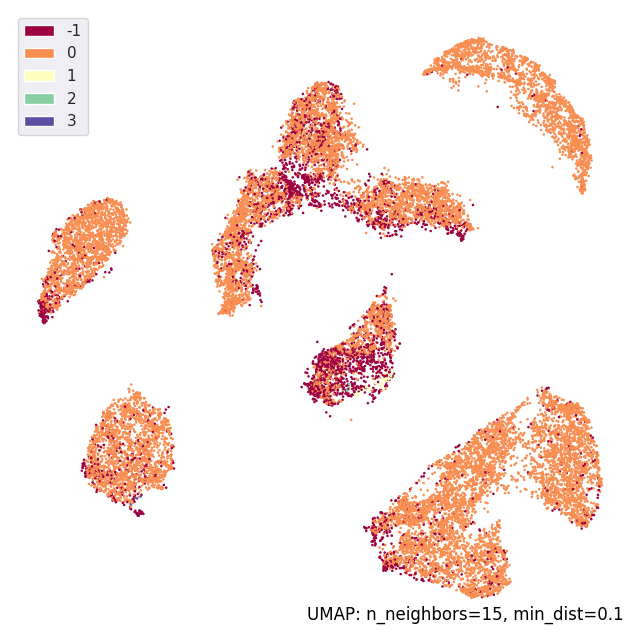

In [9]:
print('ARI : {}'.format(
    adjusted_rand_score(dbscan_tun.labels_, digit_labels)
    )
)

uplot.points(umap_obj, labels=dbscan_tun.labels_)
# eps=7
# this will result in a single cluster in a low adjusted rand index
# everything is part of the same cluster, and we have a couple of noisy data points
# eps=4
# now we have 8 clusters
# we have this cluster and we have a couple of other clusters
# but majority of data points are noise data points which is not good
# eps=6
# now we have 4 clusters
# majority of data points belong to the same cluster, meaning that this method, this choice of eps has failed us
# so now let's go on and let's change our approach

### DBSCAN with PCA

Number of PCA components 784


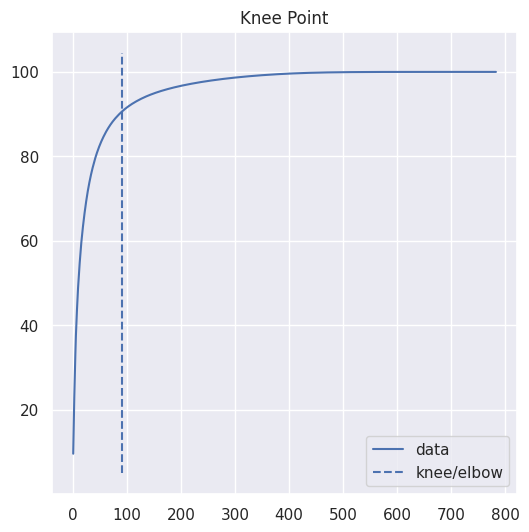

In [10]:
pca = PCA()
pca.fit(digits_data)
pca_transformed_data = pca.transform(digits_data)
print('Number of PCA components {}'.format(pca_transformed_data.shape[1]))
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)*100

kneedle = KneeLocator(
    range(len(cumulative_explained_variance)),
    cumulative_explained_variance,
    S=1.0,
    curve="concave",
    direction="increasing"
)
kneedle.plot_knee()
# it might be a good idea to embed the data with PCA and the lower the dimensionality
# top 100 components contain significant portion of dataset variation

In [11]:
pca_reduced_data = pca_transformed_data[:, :100]

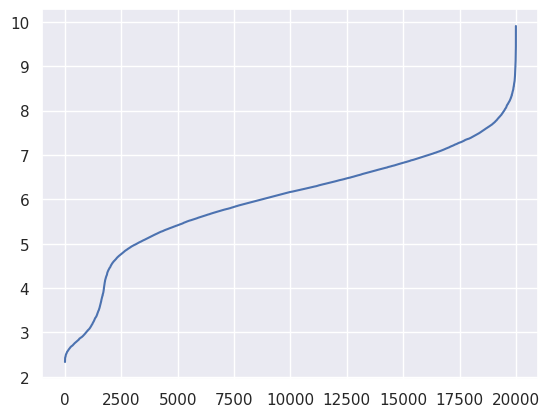

In [12]:
# and then we can use different rule of thumb for selecting the minimal number of points

# Identify MinPts
min_pts = pca_reduced_data.shape[1] + 1

# Find distances to min_pts'th neighbor
knn = NearestNeighbors(n_neighbors=min_pts+1)
knn.fit(pca_reduced_data)
distances, _ = knn.kneighbors(pca_reduced_data)


# Sort the distances to the min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

# Plot and search for a knee
plt.plot(range(sort_dist.shape[0]), sort_dist)

In [13]:
# Cluster again
dbscan_tun = DBSCAN(eps=2.5, min_samples=min_pts)
_ = dbscan_tun.fit(pca_reduced_data)

ARI : 0.005370671331482598


<Axes: >

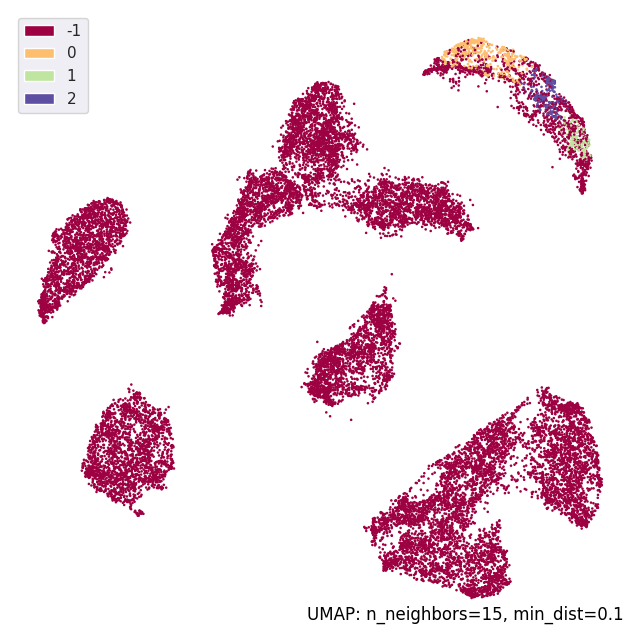

In [14]:
print('ARI : {}'.format(
    adjusted_rand_score(dbscan_tun.labels_, digit_labels)
    )
)

uplot.points(umap_obj, labels=dbscan_tun.labels_)
# eps=7
# this is no good because again, everything is a part of the same cluster
# eps=3
# we will have two clusters
# again we will manage to identify this one, but everything else will be declared as noise
# eps=2.5
# we will have higher number of clusters, but again majority of data points will be declared as noise

### Brute force search

In [ ]:
# rules of thumb proved inefficient
# the only remaining thing we can do is try out different combination values for our parameters

# Lists of candidate parameters
n_neighbor_list = [10, 20, 40, 80] + list(range(100, 600, 100))
eps_list = [1, 3, 6, 8, 10, 12]

# List to store results
result_list = []

print('Loop has started !')

# Iterate through the neighbors
for iter_i, n_neighbor in enumerate(n_neighbor_list):
    print('Done {}/{} for outter loop'.format(iter_i, len(n_neighbor_list)))

    # Take various eps thresholds and perform clustering
    for curr_eps in eps_list:
        curr_dbscan = DBSCAN(eps=curr_eps, min_samples=n_neighbor, n_jobs=-1)
        _ = curr_dbscan.fit(pca_reduced_data)
        # we will run DBscan by using our PCA embeddings in order to speed the whole thing up

        # Get number of unique clusters by removing noise
        unique_clusters = [clust for clust in set(curr_dbscan.labels_) if clust != -1]

        # we will evaluate our clustering in two ways
        # we will evaluate overall clustering where noise is considered a cluster
        # we will also evaluate clustering when it comes to all the non outlier clusters

        # Create reduced version of the data
        np_labels = np.array(curr_dbscan.labels_)
        non_noise_idx = np.where(np_labels != -1)

        non_noise_labels = np_labels[non_noise_idx]
        digit_labels_sub = digit_labels[non_noise_idx]
        pca_data_sub = pca_reduced_data[non_noise_idx]
        noise_size = np_labels.shape[0] - non_noise_labels.shape[0]

        # If number of clusters is higher than 1, calculate and
        # record the stats
        if len(unique_clusters) > 1:

            try:
                dbcv = hdbscan.validity.validity_index(pca_reduced_data, curr_dbscan.labels_, metric='euclidean')
            except:
                dbcv = -1

            result_list.append({
                'n_neigh': n_neighbor,
                'eps': curr_eps,
                'num_clust': len(set(curr_dbscan.labels_)),
                'silouethe': silhouette_score(pca_reduced_data, curr_dbscan.labels_, metric='euclidean'),
                'silouethe_sub': silhouette_score(pca_data_sub, non_noise_labels, metric='euclidean'),
                'dbcv': dbcv,
                'ari': adjusted_rand_score(digit_labels, curr_dbscan.labels_),
                'ari_sub': adjusted_rand_score(non_noise_labels, digit_labels_sub),
                'noise_size': noise_size
            })

# Obtain dataframe
result_df = pd.DataFrame.from_dict(result_list).round(3)

Loop has started !
Done 0/9 for outter loop


In [ ]:
# Sort by dbcv
best_dbcv = result_df.sort_values(by='dbcv', ascending=False).head(10).reset_index(drop=True)
best_dbcv
# the highest value is still a very low, the majority of data points are considered a noise

In [ ]:
dbscan_tun = DBSCAN(
    eps=best_dbcv.loc[0,'eps'],
    min_samples=best_dbcv.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_) # this results are no good

In [ ]:
# Sort by silouethe score
best_silouethe = result_df.sort_values(by='silouethe', ascending=False).head(10).reset_index(drop=True)
best_silouethe
# even the best silhouette score is not too good, on the other hand, the size of the noise is very low

In [ ]:
dbscan_tun = DBSCAN(
    eps=best_silouethe.loc[0,'eps'],
    min_samples=best_silouethe.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)
# we have two clusters where the one of them is invisible, and the majority of data points belong to a single cluster
# so not good

In [ ]:
# Sort by silouethe score for non-noise samples
best_silouethe_sub = result_df.sort_values(by='silouethe_sub', ascending=False).head(10).reset_index(drop=True)
best_silouethe_sub
# the silhouette score of none outlier data points isn't bad
# but again the majority of data points are declared as outliers

In [ ]:
dbscan_tun = DBSCAN(
    eps=best_silouethe_sub.loc[0,'eps'],
    min_samples=best_silouethe_sub.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)
# if we plot the clustering it is quite bad

In [ ]:
# Sort by num_clust
high_clust_num = result_df.sort_values(by='num_clust', ascending=False).head(10).reset_index(drop=True)
high_clust_num

In [ ]:
dbscan_tun = DBSCAN(
    eps=high_clust_num.loc[0,'eps'],
    min_samples=high_clust_num.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)
# now we have a higher number of clusters
# but again, a majority of class majority of data points are declared as noise

In [ ]:
# Sort by ari
best_ari = result_df.sort_values(by='ari', ascending=False).head(10).reset_index(drop=True)
best_ari
# and finally we will start cheating
# we will find the one with the best adjusted run score
# even though it is highest adjusted run score, it is very low

In [ ]:
dbscan_tun = DBSCAN(
    eps=best_ari.loc[0,'eps'],
    min_samples=best_ari.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)
# we have two clusters and bunch of outlier points
# and also we have several clusters that are merged to to each other
# so pretty bad

In [ ]:
# Sort by ari on non-noise samples
best_sub_ari = result_df.sort_values(by='ari_sub', ascending=False).head(10).reset_index(drop=True)
best_sub_ari
# if we continue cheating and use a sub of adjusted rand index, for all the non outlier data points, the agreement is actually excellent

In [ ]:
dbscan_tun = DBSCAN(
    eps=best_sub_ari.loc[0,'eps'],
    min_samples=best_sub_ari.loc[0, 'n_neigh']
)
_ = dbscan_tun.fit(pca_reduced_data)

uplot.points(umap_obj, labels=dbscan_tun.labels_)
# it is excellent because we have only managed to identify this single cluster
# and as you can see this clustering is still a no good because majority of data points are declared as noise

# so we have tried really hard in order to find parameter combination which we can actually use to cluster the data set
# but we have failed in every attempt
# and the reasons for failing is that in this data set clusters have different densities, which makes it impossible for DBscan to cluster this data
# soon we will learn about DBscan variation, which will be able to perform better, with this problem # todo_spencer